# Learning the underlying physics of a simulation model of the ocean's temperature (CIRC23)

## Context
Can data-driven models for weather and climate predictions learn the underlying physics of the system against which they are trained? Or are they simply capable of identifying statistical patterns without any clear link to the underlying physics? @furner_2022 run a sensitivity analysis of a regression-based ocean temperature model, trained against simulations from a 3D ocean model setup, demostrating that regression models are capable of learning much of the physics of the underlying system.
    
![Ocean Temperature](https://www.commondreams.org/media-library/ocean-surface-temperatures.jpg?id=33699188&width=1200&height=400&quality=90&coordinates=0%2C667%2C0%2C667)

<p><center>
Source: Image generated by the NASA and taken from Common Dreams.
</center></p>

### Purpose
This notebook aims to complement the science and methodological development embedded within the original paper, using an open infrastructure that allows users to combine interactive code with text and graphical objects, translating research outputs into findable, accessible, interoperable and reusable outputs and code.

### Description
The notebook demonstrates the inputs, the training of the regression model of ocean temperature and its sensitivity analysis.

### Highlights
* Load the necessary libraries and dependencies to run this notebook, i.e., numpy, xarray, etc.
* Fetch the original dataset used for training the regression models.
* Visualize the simulator outputs and inspect the temperature distributions near the equator, the poles, and the deep ocean.
* Showcase an example of model training for linear regression.
* Evaluate the performance of the regressors.
* Inspect the spatial distribution of the averaged errors.
* Perform a sensitivity analysis and run a series of withholding experiments.
* Summarize our findings.
* Provide contact information.

### Data
* Furner, Rachel. (2021). MITgcm Dataset for paper: Sensitivity analysis of a data-driven model of ocean temperature (v1.1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7919172
* Malhotra, Garima, Pinto-Veizaga, Daniela, & Pena, Jorge. (2023). Reproducible Challenge - Team 3 - Sensitivity analysis- Models. https://doi.org/10.5281/zenodo.7954232

<div class="alert alert-block alert-info"> <b>Note: </b> We provide the input feature arrays truncated to first 15000 points for large arrays (in trunc_io_arrays/-> data/interim/) because of space limitation. These are provided only for the withholding experiments that are required to run this notebook. For input arrays of other witholding experiments, please contact the authors. These can be provided if the users are interested in understanding the sensitivity of the regressor for other withholding experiments (not shown in this notebook). </div>

### Source code
The authors of the notebook acknowledge the original creator for providing public code available at [Regression Model OceanTemp](https://github.com/RachelFurner/RegressionModelOceanTemp). An updated and enhaced version of the code is available at [Reproducibility of "A sensitivity analysis of a regression model of ocean temperature"](https://github.com/eds-book-gallery/repro-challenge-team-3).

<div class="alert alert-block alert-info"> <b>Note: </b> Significant parts from source code were adapted or written from scratch for this notebook and the reproducible challenge. </div>

```{admonition} Project Resources
:class: dropdown

*The submitted notebook was implemented and tested within a [cloud computing infrastructure, kindly provided by the European Open Science Cloud (EOSC)](https://github.com/pangeo-data/pangeo-eosc). The following lines thoroughly described the characteristics of this environment.*

| | |
|:------- | ------:| 
|**Operating System** | Ubuntu 22.04.1|
|**Architecture**          | x86_64|
|  CPU op-mode(s)       | 32-bit, 64-bit|
|  Address sizes        | 48 bits physical, 48 bits virtual|
|  Byte Order           | Little Endian|
|**CPU(s)**                 | 128|
|  On-line CPU(s) list  | 0-127|
|**Vendor ID**              | AuthenticAMD|
|  Model name         | AMD EPYC 7543 32-Core Processor|
|    CPU family         | 25|
|    Model             | 1|
|    Thread(s) per core | 2|
|    Core(s) per socket | 32|
|    Socket(s)          | 2|
|    Stepping           | 1|
|    Frequency boost    | enabled|
|    CPU max MHz       | 2800.0000|
|    CPU min MHz        | 1500.0000|
|    BogoMIPS           | 5589.72|
|    Flags            | fpu vme de pse|
```

## Load libraries

In [1]:
# System imports
import sys
import warnings
import pandas as pd

# Data handling
import intake

# Modelling
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

# Custom functions from the authors' repo
sys.path.append("src/general/")
sys.path.append("src/pipelines/")
import CreateDataName as cn
import ReadRoutinesModifiedCloud as rr
from make_scatter_data_plots_cloud import make_scatter_plots
from make_error_data_plots_cloud import make_error_plots

# Custom functions of the reproducibility team
from constants_cloud import *

warnings.filterwarnings(action="ignore")

## Dataset
The training and validation data derive from running the Massachusetts Institute of Technology general circulation model ([MITgcm](https://zenodo.org/record/4672260#.ZFgb_S-B2pY)) —a physically based model capable of simulating the ocean or the atmosphere dynamics due to isomorphisms in the governing equations. This research project relies on a simple 2° sector configuration that captures the fundamental dynamics of the ocean, including a realistic overturning circulation. This configuration features a single ocean basin, with:
+ limited topography
+ simplified coastlines 
+ constant idealized forcing 

The domain runs from 60°S to 60° N, and is just over 20° wide in longitude. The domain is bounded by land along its northern and southern edges, and a strip of land runs along the eastern/western boundary from 60° N to 40° S.  Below this, in the southernmost 20°, the simulator has a periodic boundary condition, allowing flow that exits to the east and west to return to the domain at the western and eastern boundary. The domain has flat-bottom bathymetry of 5,000 m over most of the domain, with a 2° region of 2,500-m depth at the southernmost 20° of the eastern edge.

The simulator has:
+ 42 depth levels, with the surface layer being the thinnest at 10 m, and the bottom 10 levels being the maximum at 250 m. + 11 cells in the longitudinal direction
+ 78 cells in the latitudinal direction

The simulator has a 12-hr time step, with fields output daily. We focus on daily-mean outputs.

## Download input material

<div class="alert alert-warning">

**Note:** 
The submitted notebook (located at `notebooks/notebook_submitted.ipynb`) downloads input datasets and saved models from Zenodo repositories. This notebook version skips the download step by fetching input files directly from a cloud storage kindly provided by the [European Open Science Cloud (EOSC)](https://github.com/pangeo-data/pangeo-eosc).
    
</div>

The original dataset is available [here](https://zenodo.org/record/7919172). This dataset is used to train the regression model described in the paper.  To download this data locally, run the following line of code. Note that this process will take $\sim 1$ hour and will require at least 52 GB of available space.

```python
%%time
!bash "infrastructure/downloader_datasets.sh" > "../outputs/logs/download_datasets.txt"
```

Training this model and performing all the experiments presented in the original paper requires plenty of computing power, so, to facilitate running this notebook, we have publicly released few trained models, their predictions, and input arrays available [here](https://doi.org/10.5281/zenodo.7954232). To download this data locally, run the following line of code. This process will take $\sim 15$ minutes and requires at least $\sim 20$ GB available space.

```python
%%time
!bash "infrastructure/downloader_experiments.sh" > "../outputs/logs/download_experiments.txt"
```

## Reproduce paper
### Ocean dynamics (Figure 1)
The paper uses a  2° sector configuration to simulate ocean dynamics. This configuration features a single ocean basin, with limited topography, simplified coastlines, and constant idealized forcing. This has been used in a number of idealized simulations of Southern Ocean processes and their impacts on the global circulation. This configuration, while relatively simple, captures the fundamental dynamics of the ocean, including a realistic overturning circulation.

In the following script, we load the MITGCM DATASET and visualize the configuration used to simulate the ocean dynamics. Focusing particuarly on:

<ol style="list-style-type: lower-alpha">
<li>Temperature (°C) at 25 m below the surface for one particular day.</li>
<li>Change in temperature between over 1 day at 25 m below the surface.</li>
<li>Standard deviation in temperature at 25 m below the surface.</li>
<li>Temperature (°C) at 25 m below the surface and 13° E for one particular day.</li>
<li>Change in temperature between over 1 day in temperature at 25 m below the surface & 13° E.</li>
<li>Standard deviation in temperature at 25 m below the surface & 13° E.</li>
<li>Time series at 57° N, 17° E, and −25 m.</li>
<li>Time series at 55° S, 9° E, and −25 m.</li>
</ol>


 LOADING MITGCM DATASET 


Reading in MITGCM dataset ...


Shape of dataset: (2, 42, 78, 11)













 25 M BELOW THE SURFACE FOR ONE PARTICULAR DAY 


Temperature (°C) at 25 m below the surface for one particular day.


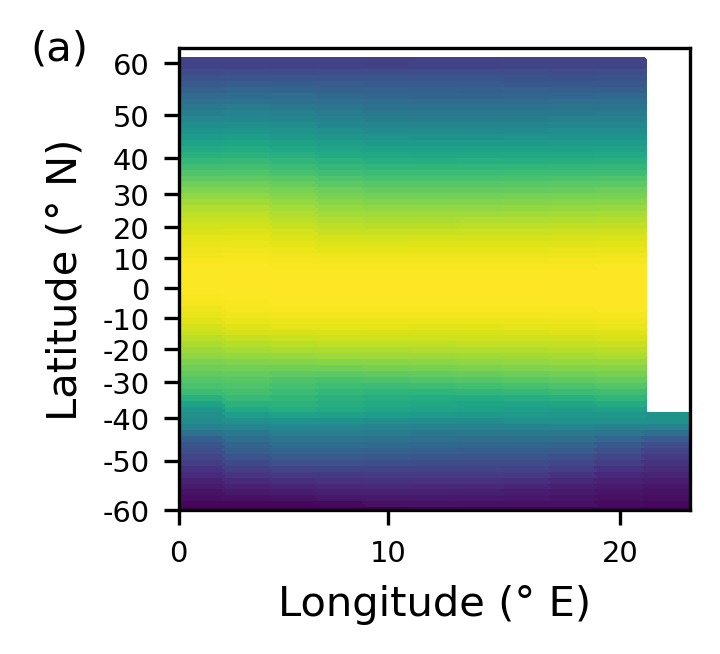

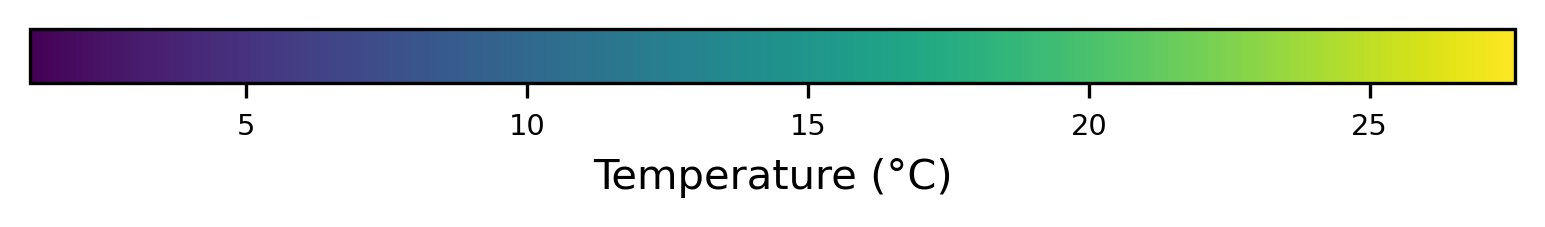

Change in temperature between over 1 day at 25 m below the surface.


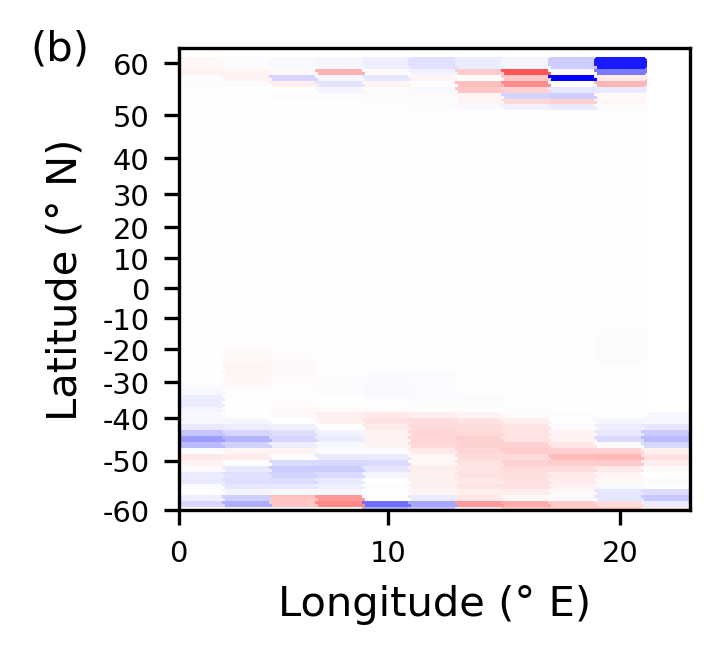

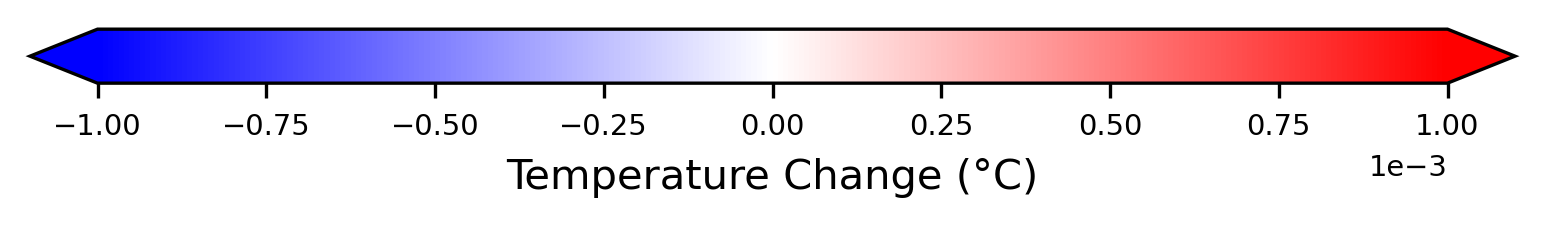

Standard deviation in temperature at 25 m below the surface.


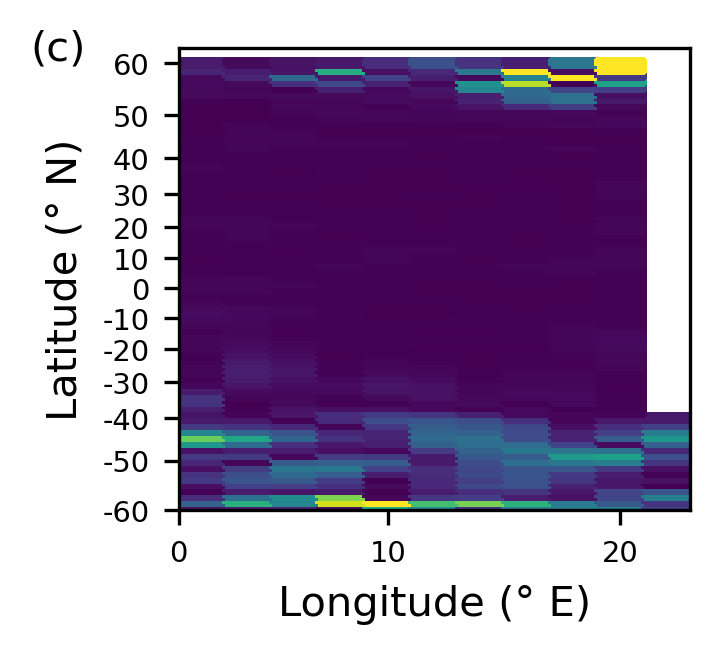

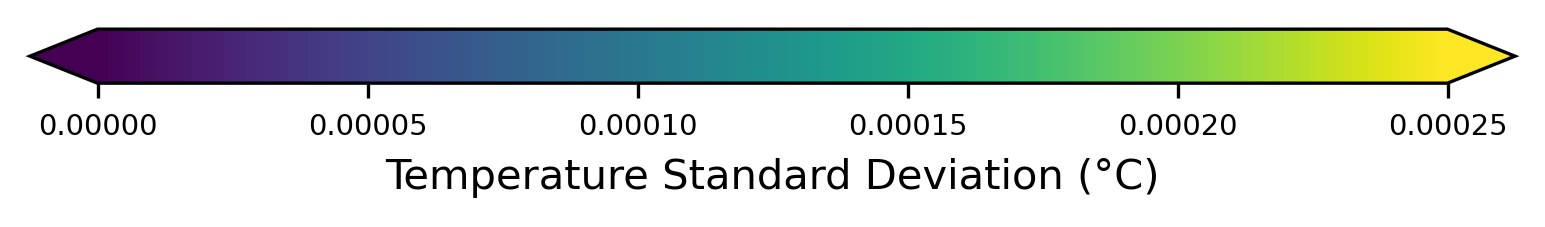











 25 M BELOW THE SURFACE & AT at 13° E FOR ONE PARTICULAR DAY 


Temperature (°C) at 25 m below the surface & at 13° E for one particular day.


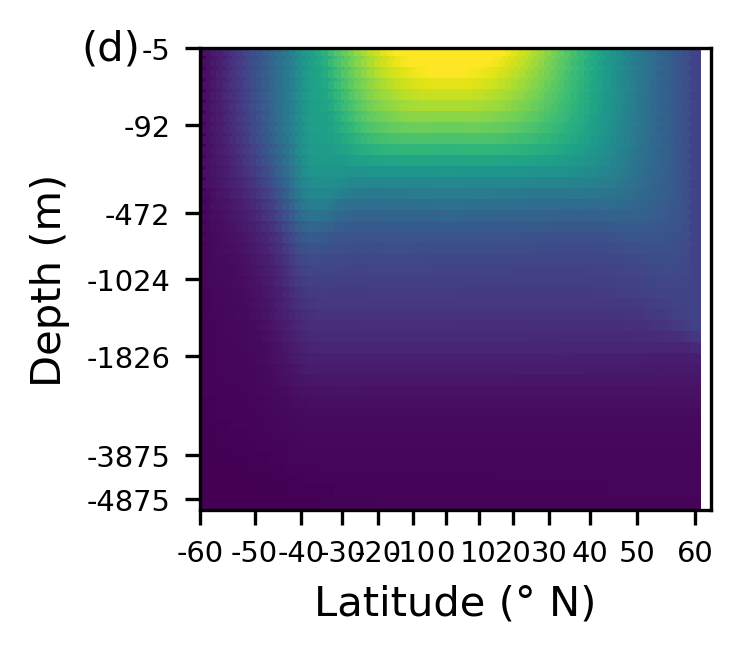

Change in temperature between over 1 day in temperature at 25 m below the surface & at 13° E.


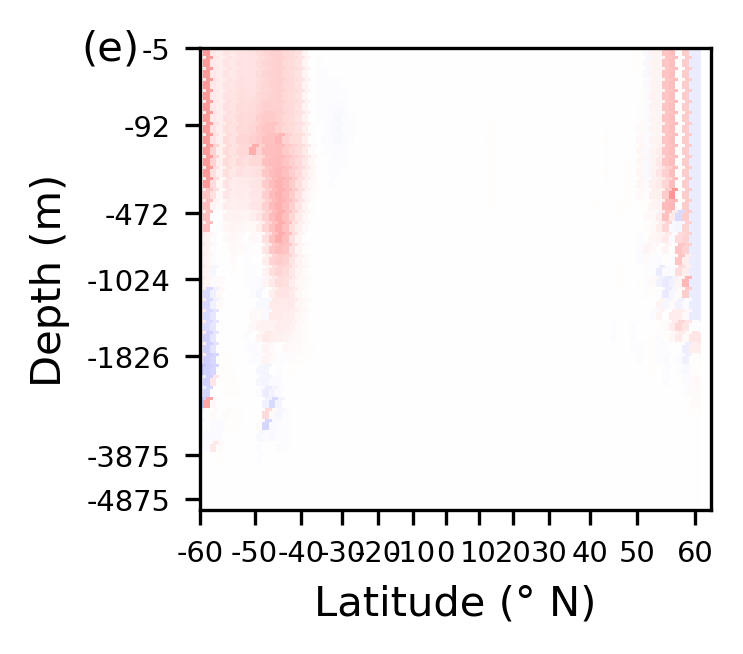

Standard deviation in temperature at 25 m below the surface & at 13° E.


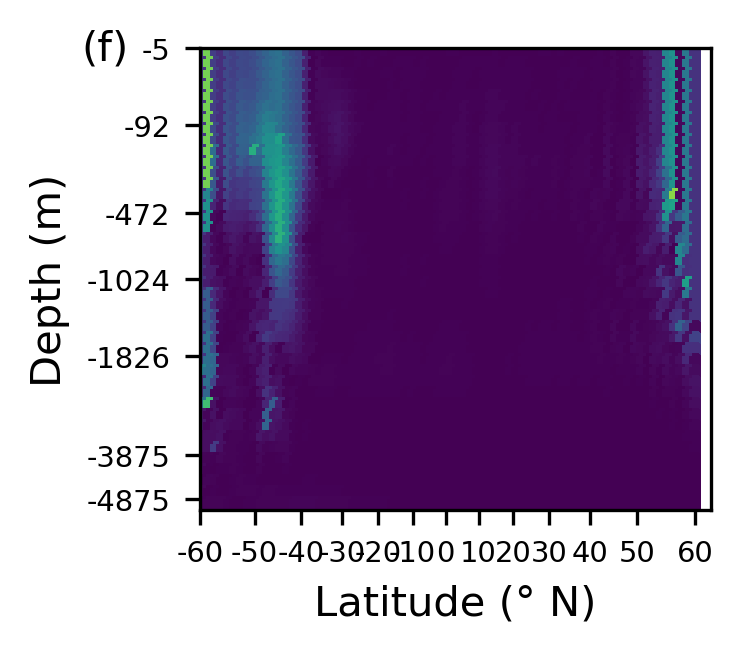











  TIME SERIES AT 57° N, 17° E, and −25 m 




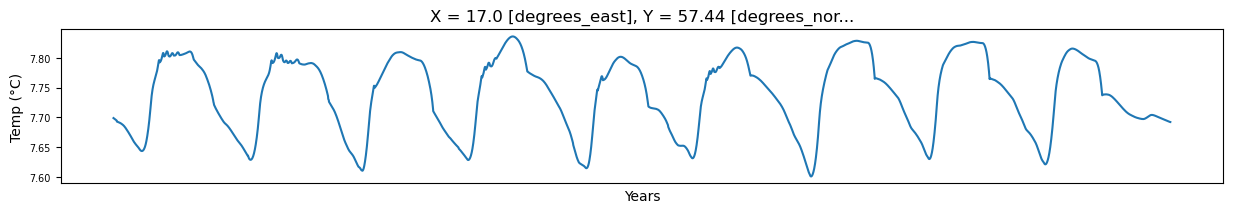











  TIME SERIES AT 55° S, 9° E, and −25 m 




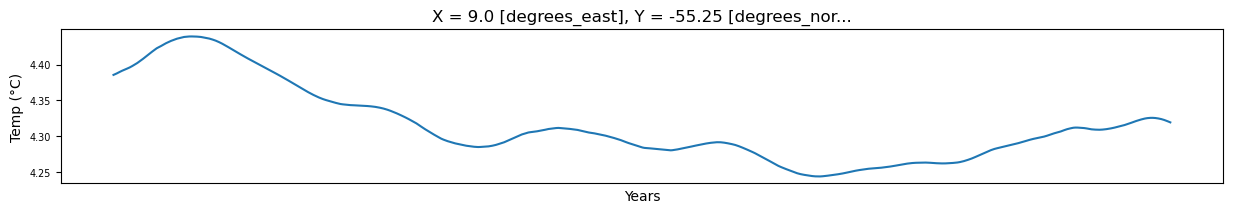

In [2]:
%run "src/pipelines/graphs_section_cloud.py"

Notice that the domain:
+ runs from  60°𝑆 to  60°𝑁, and is just over  20° wide in longitude. 
+ is bounded by land along the northern (and southern) edge, and a strip of land runs along the eastern (and western) boundary from 60°.
  N to  40°𝑆 (see Figure 1a). Below this, in the southernmost 20°, the simulator has a periodic boundary condition, allowing flow that exits to the east (west) to return to the domain at the western (eastern) boundary. 
+ has flat-bottom bathymetry of 5,000 m over most of the domain, with a 2° region of 2,500-m depth at the southernmost 20° of the eastern edge (i.e., the spit of land forming the eastern boundary continues to the southern boundary as a 2,500-m high subsurface ridge).

Importantly, note from the figures presented, that the depth axis is scaled to give each GCM grid cell equal spacing. The simulator shows a realistic temperature distribution with warm surface water near the equator, and cooler water near the poles and in the deep ocean. Temperature changes are largest in the very north of the domain and throughout the southern region. Though changes per day are small, they accumulate over time to give cycles of around 0.2° in some regions of the domain.

## Model training
Model training is performed for the purely linear regression model (only linear terms) and the nolinear regression model (linear and multiplicative terms). Run parameters for the control and withholding experiments were set through the `run_vars` variable in the script `src/pipelines/TrainLinearRegressionModel.py`.

### Linear regression (A toy example)
For illustrative purposes, in the following section we showcase how to set parameters for a linear regression model that takes as input all the relevant variables, that is,:
> Temperature, salinity, U (East–West) and V (North–South) current components, density, U, V, and W (vertical) components of the Gent-McWilliams (GM) bolus velocities, sea surface height (SSH), latitude, longitude, and depth. The GM bolus velocities are a parameterization of the velocities resulting from ocean eddies and are used in the GM scheme to calculate the advective effects of eddy action on tracers.

First, we define a dictionary named `run_vars`, which has all the input variables set to `True` and, `poly_degree` set to `1` -- the latter parameter defines we will be running a purely linear regression.

In [3]:
# Run parameters
run_vars = {
    "dimension": 3,
    "lat": True,
    "lon": True,
    "dep": True,
    "current": True,
    "bolus_vel": True,
    "sal": True,
    "eta": True,
    "density": True,
    "poly_degree": 1,
    "StepSize": 1,
    "predict": "DelT",
}
data_name = data_prefix + cn.create_dataname(run_vars)

The following chunk of code performs the following tasks:
+ loads the MITGCM data into input and output arrays.
+ splits the dataset into training, validation and testing samples.
+ normalises the dataset.
+ saves the datasets into 1) norm_outputs_tr, array containing the normalized outputs that will be used for training, 2) norm_outputs_val, containing the normalized outputs that would be used for validation.

The training-validation split ratio is set by default to $0.7$, while the validation-testing split ratio is set to $0.9$.

In [4]:
# Load the data
cat = intake.open_catalog("data/inputs_paper.yml")

mitgcm_filename = cat["MITGCM_model"]
density_file = cat["density_data"]
clim_filename = cat["clim_data"]
trainval_ratio = 0.7
valtest_ratio = 0.9

(
    norm_inputs_tr,
    _,
    _,
    norm_outputs_tr,
    norm_outputs_val,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
) = rr.ReadMITGCM(mitgcm_filename, clim_filename, density_file, data_name, run_vars)

Shape of density dataset:  (18000, 42, 78, 11)


*********************************


Number of training & validation samples > 0.0005: [171979], [52235]


Number of training & validation samples > 0.001:  [111033], [34604]


Number of training & validation samples > 0.002:  [82846], [25565]


Number of training & validation samples > 0.0025: [76097], [23495]


Number of training & validation samples > 0.003:  [70810], [22054]


Number of training & validation samples > 0.004:  [62849], [19632]


Number of training & validation samples > 0.005:  [56885], [17853]
*********************************
Highest and lowest values in training data:   0.26704645, -0.23875284
Highest and lowest values in validation data: 0.23960555, -0.26727915
Mean of train and val sets : -5.388849e-05, 0.0001357027
Std  of train and val sets : 0.01036672, 0.011045901
Skew of train and val sets : [-1.0299234], [-0.20501705]
Kurtosis of train and val sets : [101.97883], [98.24192]
Normalising Data


Shape for inputs and outputs: tr; val; te
(648440, 228) (648440, 1)
(199520, 228) (199520, 1)
(99760, 228) (99760, 1)
Shape for orig_temp and clim_temp, tr&val
(648440, 1) (199520, 1)
(648440, 1) (199520, 1)


#### Model fit example

After splitting our dataset into the corresponding subsamples (training, validation and testing), we proceed to train the model setting the following  hyperparameter:
+ $\alpha = 0.001$

Our cross-validation splitting strategy is set to $3$ folds.

In [5]:
# Model hyperparameters for the grid search
parameters = [{"alpha": [0.001]}]
n_folds = 3
lr = linear_model.Ridge(fit_intercept=False)
lr = GridSearchCV(
    lr, param_grid=parameters, cv=n_folds, scoring="neg_mean_squared_error", refit=True
)

# Fit the model
lr.fit(norm_inputs_tr, norm_outputs_tr)
# Parameters for the estimator.
pd.DataFrame.from_dict(lr.get_params(), orient="index", columns=["values"])

,values
cv,3
error_score,NaN
estimator__alpha,1.0
estimator__copy_X,True
estimator__fit_intercept,False
estimator__max_iter,None
estimator__positive,False
estimator__random_state,None
estimator__solver,auto
estimator__tol,0.0001


### Performance of the regressor
#### Scatter plot for the control regressor (Figure 2) - Different from above
We update the dictionary `run_vars`, such that `poly_degree` is set to `2` -- This helps us in defining the model so that it has second-order pairwise polynomial terms, in order to capture a limited amount of nonlinear behavior through interaction between terms. This means that as well as the above inputs, we have multiplicative pairs of features

In [6]:
# Setting up the parameters for the run
run_vars = {
    "dimension": 3,
    "lat": True,
    "lon": True,
    "dep": True,
    "current": True,
    "bolus_vel": True,
    "sal": True,
    "eta": True,
    "density": True,
    "poly_degree": 2,
    "StepSize": 1,
    "predict": "DelT",
}
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix + data_name

<div class="alert alert-warning">

**Note:** 
Some models were trained using large input datasets which will not work in the memory available of the standard Binder. Therefore, below we display the code needed for loading the input data in a markdown cell, rather than an executable cell. Instead, in the Sensitivity analysis (Figure 5) section we demonstrate how steps below work on another model which fits the memory and run the prediction function.
</div>

```python
# Open data
cat = intake.open_catalog('data/inputs_models.yml')

#Loading Input Feature Arrays
norm_inputs_tr=cat[model_name].to_dask()['norm_inputs_tr']
norm_inputs_val=cat[model_name].to_dask()['norm_inputs_val']
```

The following script performs the following steps to make the scatter plot of predicted and true temperature change, allowing us to evaluate the performance of the control regressor.

<ol style="list-style-type: lower-alpha">
<li>Load the true temperature change arrays, persistence arrays to calculate climatology.</li>
<li>Load the trained model.</li>
<li>Calculate the predicted temperature changes using the input feature arrays and the trained model.</li>
<li>Denormalise the predictions and true outputs using the mean and standard deviation of the arrays.</li>
<li>Calculate the mean squared errors and make the scatter plot using the denormalized arrays.</li>
</ol>

```python
make_scatter_plots(run_vars,data_name,model_name,norm_inputs_tr,norm_inputs_val,lim=15000,fig_prefix='fig2')
```

The model captures the central part of the distribution well. While the majority of the temperature change is dominated by small near-zero changes, capturing these is key to producing a good forecast system. To a lesser extent, the regressor also captures the tails of the distribution, where temperature changes are larger, although the underprediction is more significant here. However, it is noteworthy that the model still shows some skill for these points, given that the model used is very simple and there are a relatively limited number of training samples in the tails.

#### Spatial patterns of errors (Figure 3)
To understand how the regressor performs spatially, temporally averaged absolute errors are plotted. 
These averaged errors are shown in Figure 3. Note that the regressor is only applied away from boundary and land points (in its current form, it cannot deal with spatial locations that are not surrounded on all sides by ocean points); hence, points close to land are not included in these plots. The script below performs the following steps:

<ol style="list-style-type: lower-alpha">
<li>It loads the the MITgcm state at 500 different times from the 20-year dataset, masks the locations that are not surrounded on all sides by ocean points, and uses these fields as inputs to the regressor to forecast a single time step ahead.</li>
<li>The set of forecasts created from these 500 input states is compared to the truth from the GCM run, and the absolute errors between the truth and the predictions are then temporally averaged.</li>
</ol>

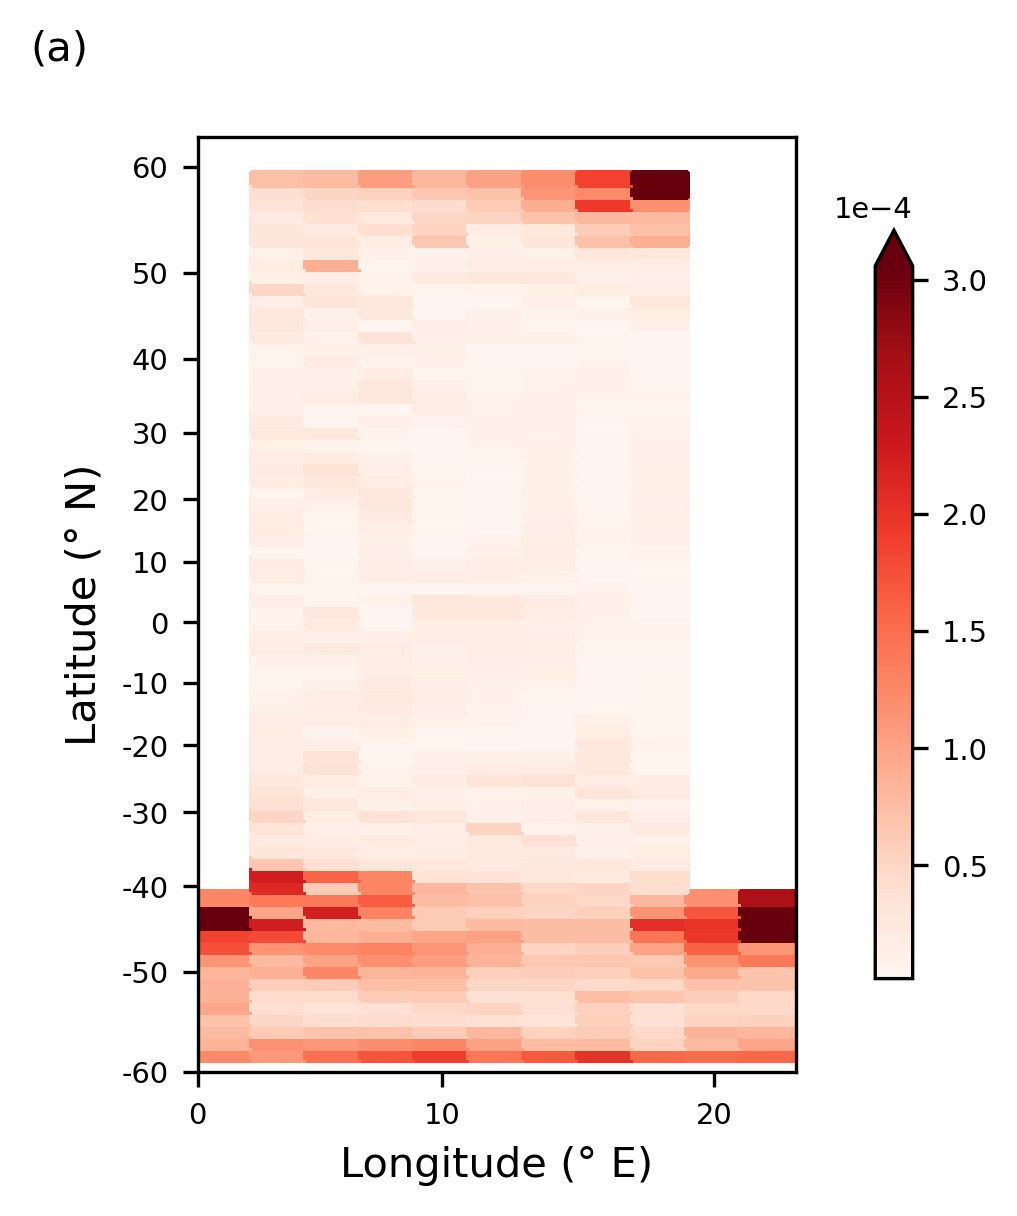

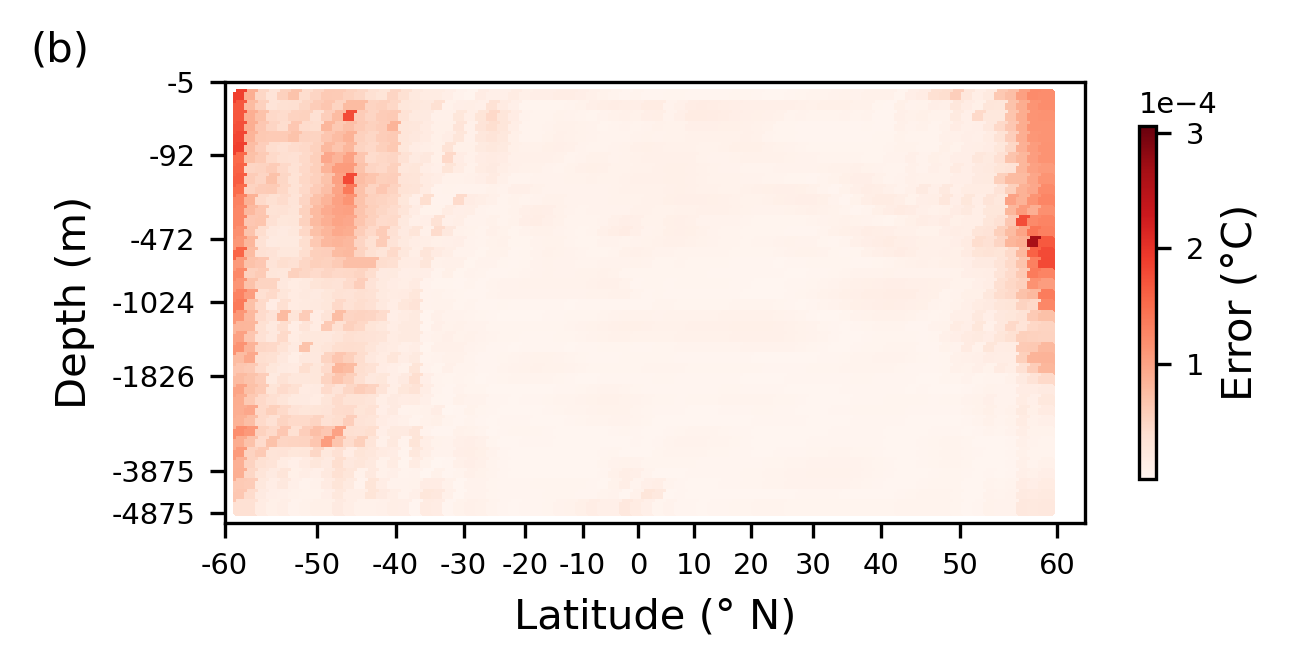

In [7]:
%run "src/pipelines/spatial_patterns_errors_cloud.py"

The regressor shows the largest errors are located in the north of the domain and in the Southern Ocean. We see that the errors in the north of the domain are co-located with regions of high vertical advective temperature fluxes, and regions of high convective fluxes. These results imply the regression model struggles to fully capture the vertical processes, and the associated heat flux, in the north of the domain. The high errors in the Southern Ocean are again co-located with regions of high vertical diffusive fluxes, this time both explicit and implicit, and vertical advection.  Throughout the ocean interior where temperature changes and the fluxes associated with these are small, errors are also small as would be expected.

### Sensitivity analysis
#### Coefficient analysis (Figure 4)
Figure 4a shows coefficients averaged over all input locations for each variable type (i.e., for most variables, there are 27 inputs, corresponding to the 27 neighboring cells; we average over these to give a single value for each variable (temperature, salinity, etc.) and for each polynomial combination of variables). 

Figure 4b shows the coefficients related to polynomial interactions of temperature with temperature. These are the raw coefficients, without any averaging applied.

raw_coeffs.shape
(1, 26106)
raw_coeffs.shape
(1, 26106)


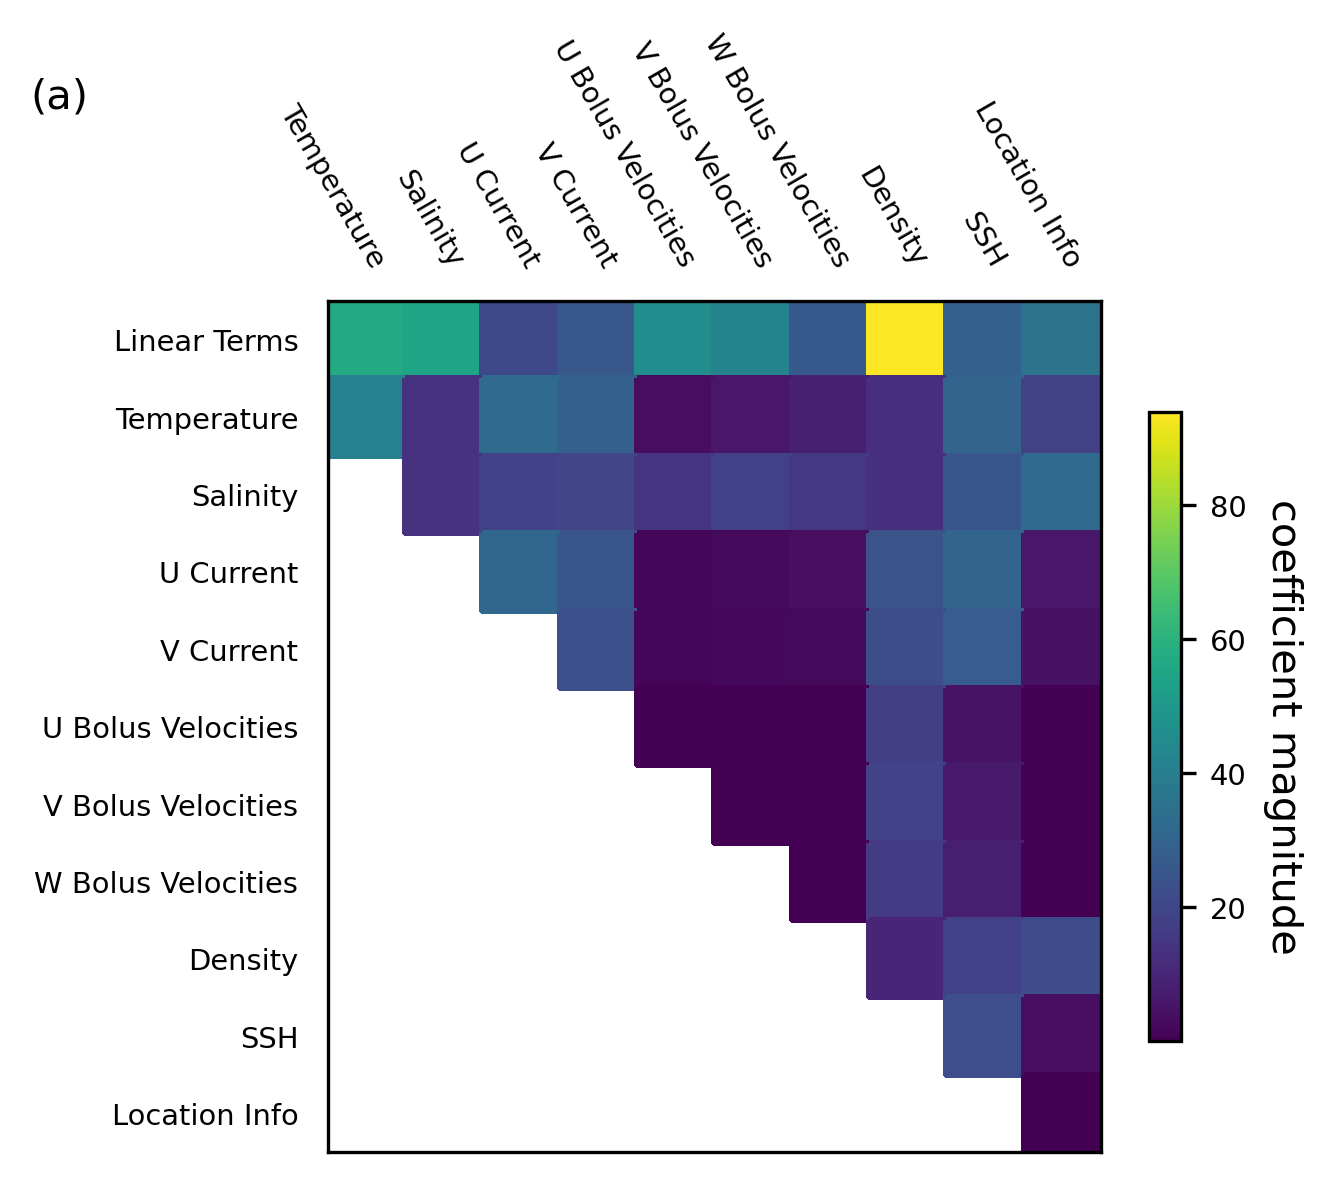

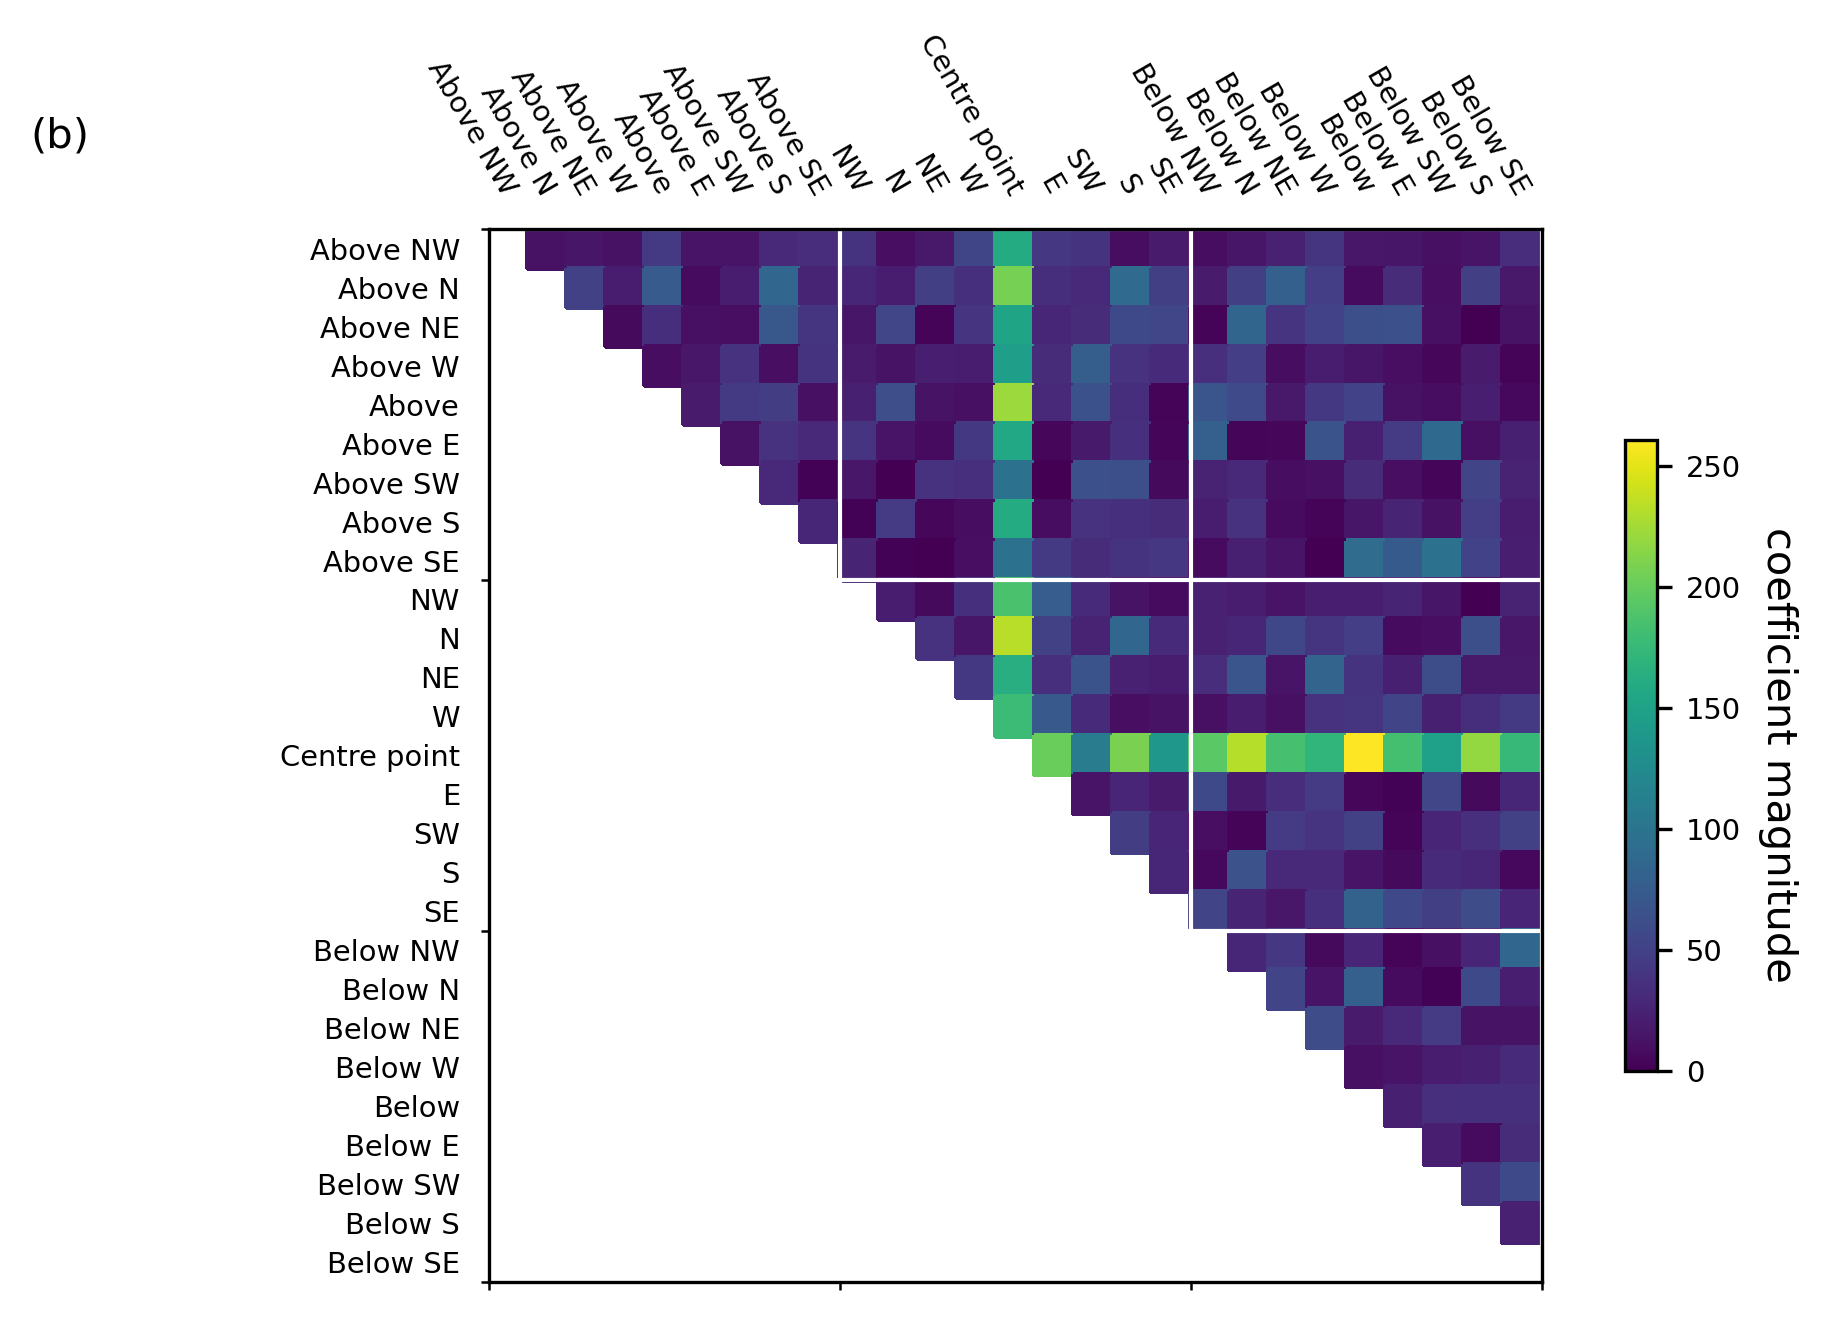

In [8]:
%run "src/pipelines/coecien_analysis_cloud.py"

High-weighted inputs (those with a large magnitude coefficient) are variables which are heavily used in the predictions and therefore considered important for the predictive skill. From the above figures we infer: 

<ol style="list-style-type: lower-alpha">
<li>From Figure 4a: Density (as a linear term, not in combination with other variables) is by far the most highly weighted variable in this model. This agrees well with the current physical understanding of ocean dynamics.</li>
<li>From Figure 4a: The location information is low weighted, particularly when interacting with other variables. This indicates that the regressor is not basing its predictions predominantly on the location of points, but on the physical variables themselves.</li>
<li>From Figure 4b: Multiplicative interaction between temperatures at the grid point we are predicting for and the temperature at all surrounding points is very highly weighted. This fits well with our physical expectation of the system—as diffusive and advective fluxes of temperature are dominated by local gradients in temperature.</li>
</ol>
    
#### Witholding experiments
In this section, we run a series of withholding experiments. For each of the variables described with the exception of temperature, we train a new regressor leaving out that one variable group, for example, we train a new regressor with all the existing inputs except for salinity at all surrounding points and any multiplicative terms including salinity.

##### Withholding multiplicative terms: Figure 5; Importance of Non-Linearity
We update the dictionary `run_vars`, such that `poly_degree` is set to `1` -- This helps us in evaluating the performance of the purely linear model, that is, the model trained without any multiplicative terms.

In [9]:
# Setting up the parameters for the run - Setting Polynomial Degree=1
run_vars = {
    "dimension": 3,
    "lat": True,
    "lon": True,
    "dep": True,
    "current": True,
    "bolus_vel": True,
    "sal": True,
    "eta": True,
    "density": True,
    "poly_degree": 1,
    "StepSize": 1,
    "predict": "DelT",
}
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix + data_name

In [10]:
# Path to the input arrays from an intake catalog
cat = intake.open_catalog("data/inputs_models.yml")

inputs_tr_filename = cat[model_name](partition="Tr")
inputs_val_filename = cat[model_name](partition="Val")

# Loading Input Arrays
norm_inputs_tr = inputs_tr_filename.to_dask()["norm_inputs_tr"]
norm_inputs_val = inputs_val_filename.to_dask()["norm_inputs_val"]

predict values



  Predictions against truth for Training datasets for the control regressor 




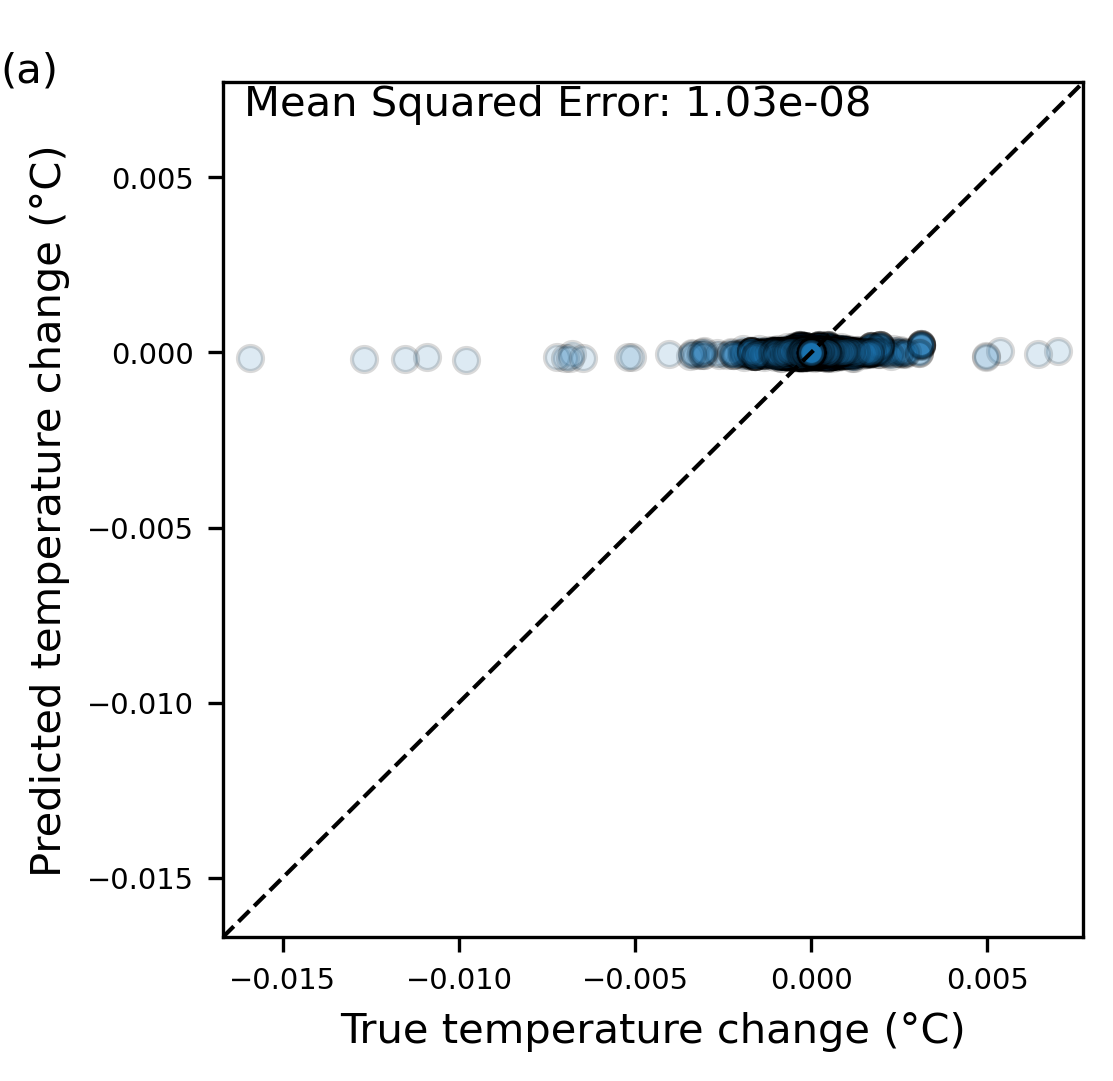

In [11]:
make_scatter_plots(
    run_vars,
    data_name,
    model_name,
    norm_inputs_tr,
    norm_inputs_val,
    plot_val=False,
    fig_prefix="fig5",
)

We see that, without multiplicative terms, the model can capture the mean behavior of the system (zero change in temperature) but is unable to capture any of the variability. This mean behavior alone does not provide useful forecasts, as can be seen from the statistics for this experiment. Nonlinearity is shown to be critical to modeling the variability of temperature change.

##### Withholding 3D structure: Figure 6; Impact of vertical structure

To assess how information about the vertical structure of the ocean impacts predictions, we look at spatially averaged errors from the model trained with only a 2D neighborhood of inputs, along with the difference in error between this and the control regressor from previous Section.

We update the dictionary `run_vars`, such that `dimension` is set to `2`.

In [12]:
# Loading the 2D model
run_vars = {
    "dimension": 2,
    "lat": True,
    "lon": True,
    "dep": True,
    "current": True,
    "bolus_vel": True,
    "sal": True,
    "eta": True,
    "density": True,
    "poly_degree": 2,
    "StepSize": 1,
    "predict": "DelT",
}
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix + data_name
exp_name = exp_prefix + model_name
cntrl_name = (
    exp_prefix
    + model_prefix
    + data_prefix
    + "3dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT"
)

In [13]:
exp_name

'alpha.001_2dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT'



 Plotting the absolute error from predictions across the grid at 500 different times averaged to give a spatial pattern of errors. 




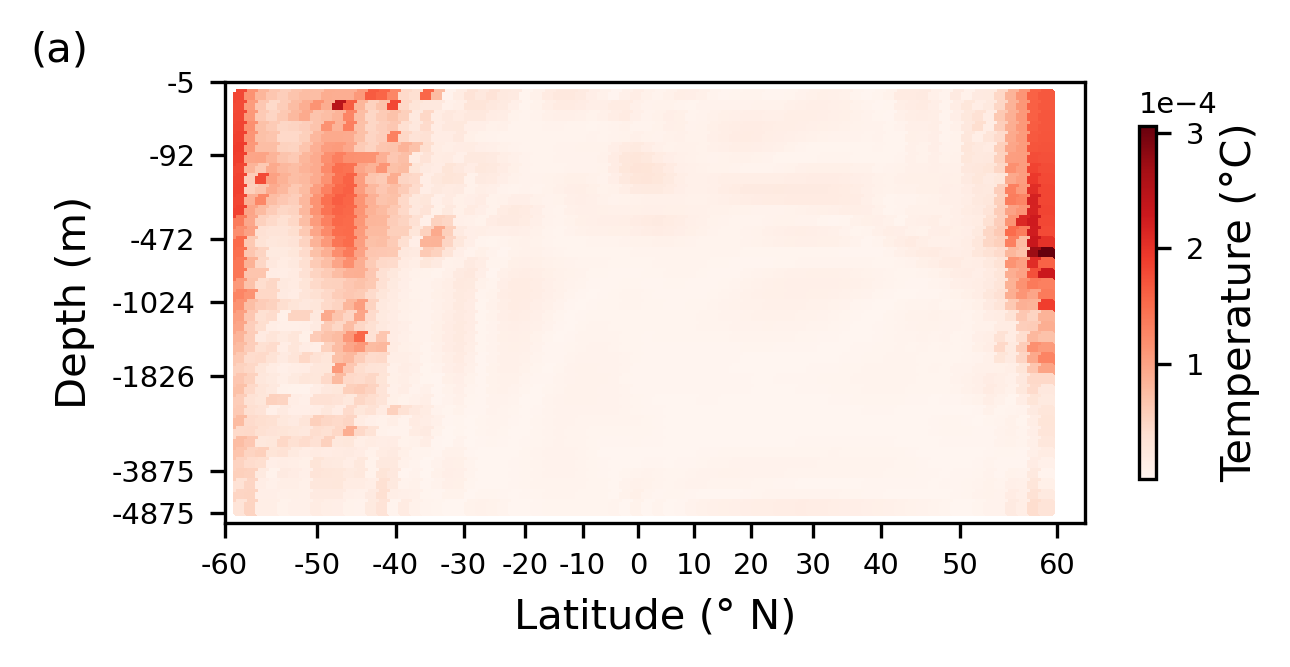



 Plotting the difference between this and the control run, with areas shaded in red indicating where the error has increased as a consequence of withholding information about the vertical structure, and blue indicating areas where the predictions are improved. 




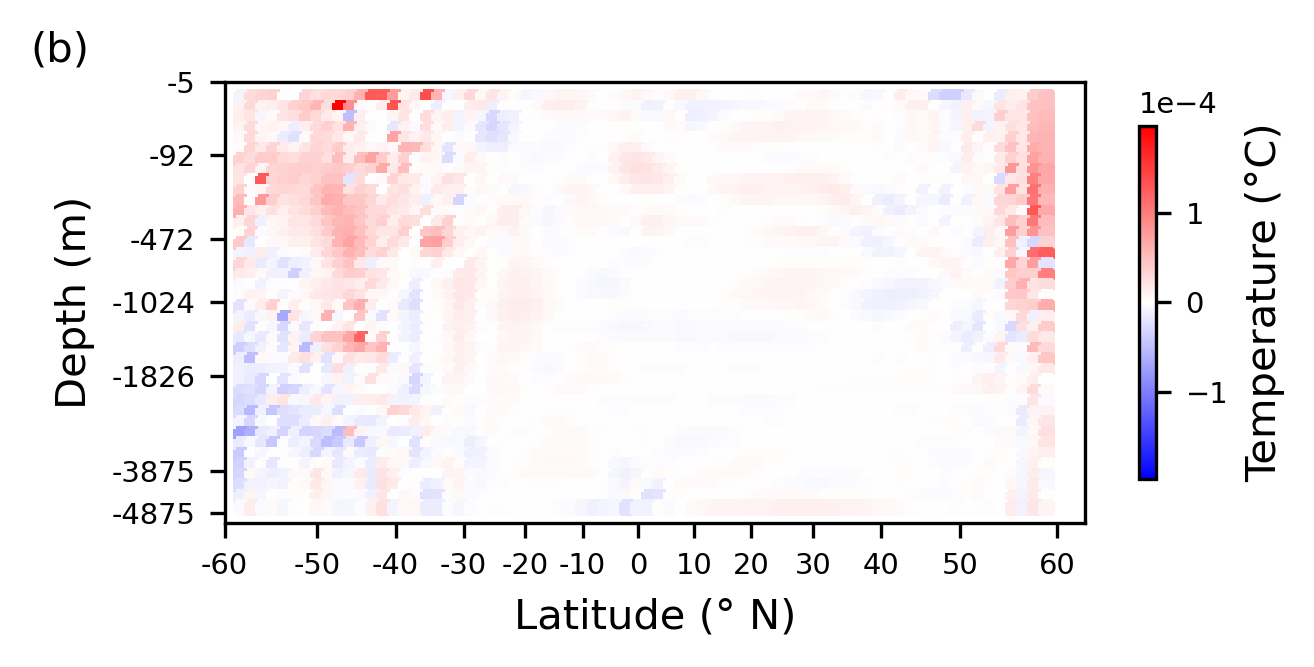

In [14]:
make_error_plots(mitgcm_filename, exp_name, cntrl_name, fig_prefix="fig6")

Interestingly, this regressor shows some regions (the deep water in the south of the domain) where the errors are notably improved in a regressor using only 2D information. In this work, we have developed a regressor which learns one equation to be applied across all grid boxes in the domain. We optimize for best performance averaged over all relevant grid cells, but this does not enforce the best possible performance over each individual grid point/region, and so some of the resultant models will favor certain types of dynamics more than others. Given this, it is not unexpected that the new equations discovered for the withholding experiments (which again optimize for best performance averaged over the entire domain interior) may outperform the control in some locations, despite being poorer overall. Here, we see that the control model is able to perform well across the domain, and optimizes for good performance overall, rather than the much more varied performance seen in the withholding experiments. It seems that as the model which withholds vertical information is not capable of performing well in many regions of the domain, a solution is found which highly optimizes performance in other regions to minimize error overall.

##### Withholding currents: Figure 7; Impact of currents
We update the dictionary `run_vars`, such that `current` is set to `False` -- This helps us in evaluating the impact of currents on the performance of the model.

In [15]:
# Setting the run parameters
run_vars = {
    "dimension": 3,
    "lat": True,
    "lon": True,
    "dep": True,
    "current": False,
    "bolus_vel": True,
    "sal": True,
    "eta": True,
    "density": True,
    "poly_degree": 2,
    "StepSize": 1,
    "predict": "DelT",
}
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix + data_name
exp_name = exp_prefix + model_name
cntrl_name = (
    exp_prefix
    + model_prefix
    + data_prefix
    + "3dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT"
)

In [16]:
exp_name

'alpha.001_3dLatLonDepBolSalEtaDnsPolyDeg2_Step1_PredictDelT'



 Plotting the absolute error from predictions across the grid at 500 different times averaged to give a spatial pattern of errors. 




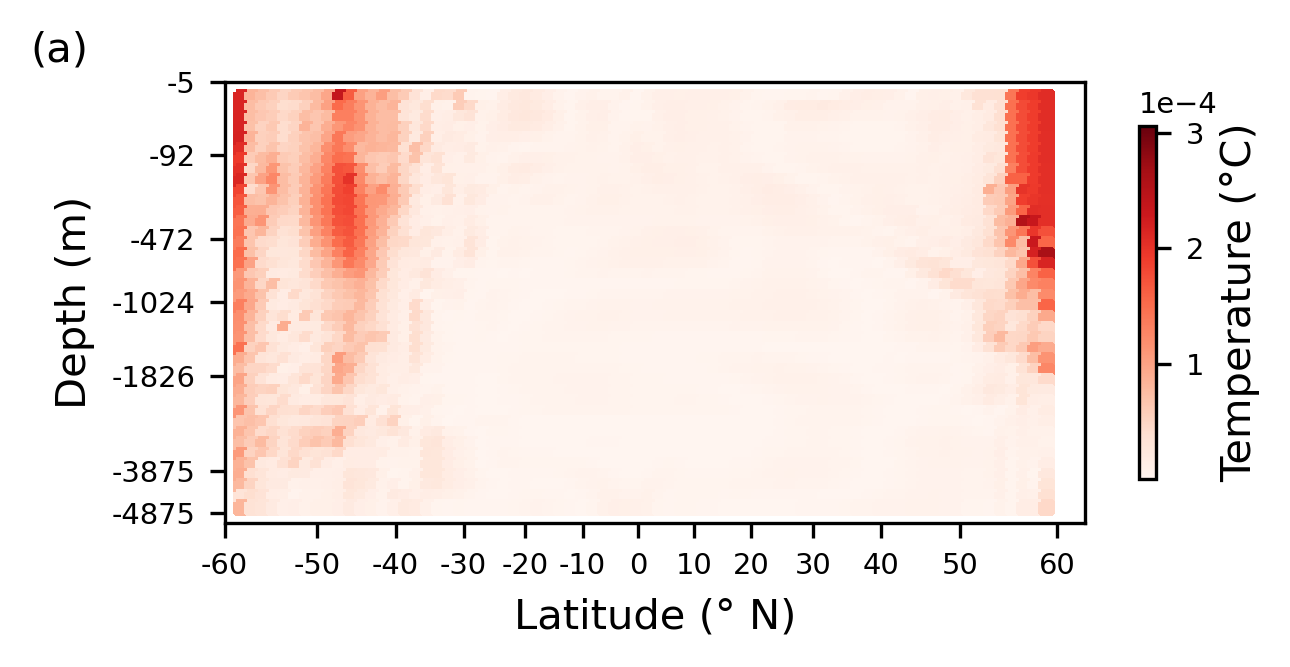



 Plotting the difference between this and the control run, with areas shaded in red indicating where the error has increased as a consequence of withholding information about the vertical structure, and blue indicating areas where the predictions are improved. 




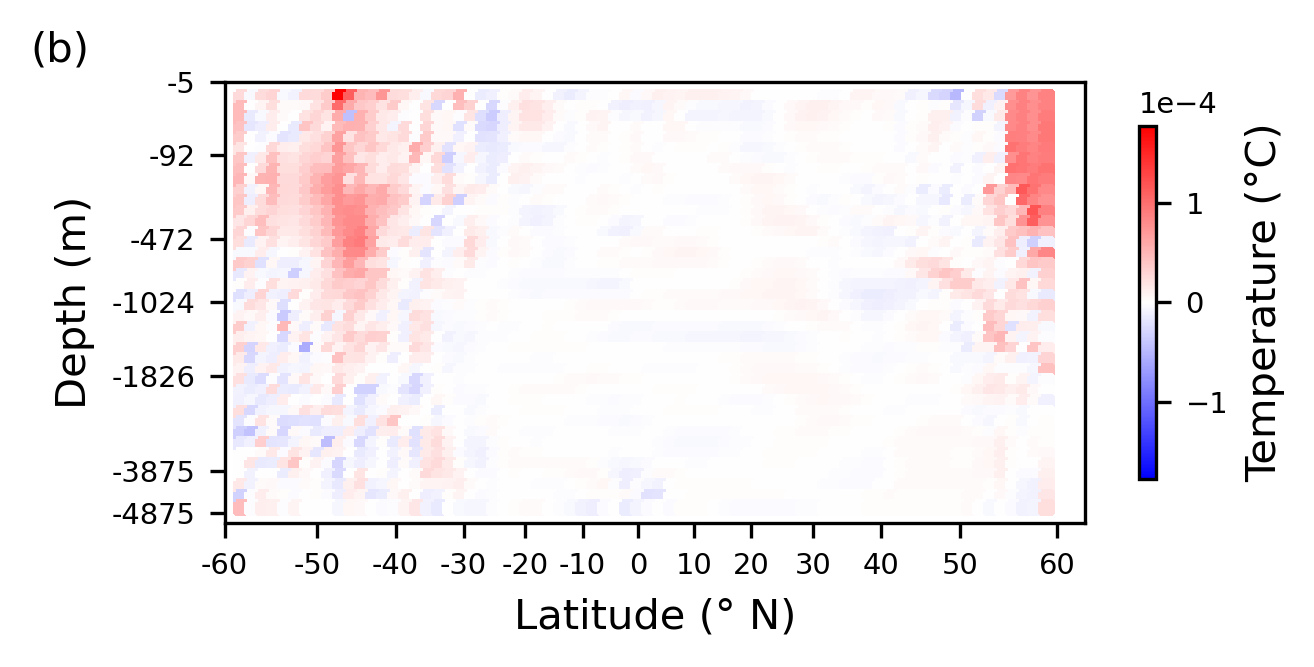

In [17]:
make_error_plots(mitgcm_filename, exp_name, cntrl_name, fig_prefix="fig7")

The horizontal (U and V) components of the currents directly drive horizontal advection of temperature. They are also indirectly related to horizontal diffusion, as this is increased in regions of high currents and steep gradients. As such, we would expect that suppressing information about the horizontal currents would cause increases in error in regions where horizontal advection and horizontal diffusion is high. However, again, we note that this region of increased error is one where many processes are present, and the increased errors seen also coincide, to a lesser extent, with regions of high vertical processes (advection, diffusion, and convection), which is less in line with our physical understanding. Here, errors appear more closely matched to the horizontal processes, and so a reasonable interpretation is that the model here is behaving as expected.

## Summary
* There has been much recent interest in developing data-driven models for weather and climate predictions. However, there are open questions regarding their generalizability and robustness, highlighting a need to better understand how they make their predictions. In particular, it is important to understand whether data-driven models learn the underlying physics of the system against which they are trained, or simply identify statistical patterns without any clear link to the underlying physics. 
* In this notebook, we run a sensitivity analysis of a regression-based model of ocean temperature, trained against simulations from a 3D ocean model setup in a very simple configuration. 
* We show that the regressor heavily bases its forecasts on, and is dependent on, variables known to be key to the physics such as currents and density. By contrast, the regressor does not make heavy use of inputs such as location, which have limited direct physical impacts. 
* The model requires nonlinear interactions between inputs in order to show any meaningful skill—in line with the highly nonlinear dynamics of the ocean. Further analysis interprets the ways certain variables are used by the regression model. 
* We see that information about the vertical profile of the water column reduces errors in regions of convective activity, and information about the currents reduces errors in regions dominated by advective processes. 
* Our results demonstrate that even a simple regression model is capable of learning much of the physics of the system being modeled. We expect that a similar sensitivity analysis could be usefully applied to more complex ocean configurations.

## Citing this Notebook

Please see [CITATION.cff](https://github.com/eds-book/3286b92f-4fae-4cc6-a29e-e408bc844542/blob/main/CITATION.cff) for the full citation information. The citation file can be exported to APA or BibTex formats (learn more [here](https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/about-citation-files)).

## Additional information

**Review**: This notebook has been reviewed by one or more members of the Environmental Data Science book community. The open review is available [here](https://github.com/alan-turing-institute/environmental-ds-book/issues/172).

**Dataset**: Malhotra, Garima, Pinto-Veizaga, Daniela, & Pena, Jorge. (2023). Reproducible Challenge - Team 3 - Sensitivity analysis- Models. https://doi.org/10.5281/zenodo.7954232 - Version 1

Furner, Rachel. (2021). MITgcm Dataset for paper: Sensitivity analysis of a data-driven model of ocean temperature (v1.1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7919172 - Version 1.1

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/main/LICENSE).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or or send a direct message to environmental.ds.book@gmail.com.

In [18]:
from datetime import date

print('Notebook repository version: v2025.6.0')
print(f'Last tested: {date.today()}')

Notebook repository version: v2025.6.0
Last tested: 2025-07-01
